Initial Imports

In [193]:
import csv
import time
import numpy as np
import openmeteo_requests
import requests_cache
from retry_requests import retry
import pandas as pd
from datetime import datetime, timedelta
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Generate map of cities and their respective coordinates

In [174]:
# Replace 'file.csv' with your CSV file's name and path
file_path = 'data/tr.csv'

# Create an empty dictionary to store city coordinates
city_coordinates = {}

# Open the CSV file and read data
with open(file_path, newline='', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        city = row['city']
        lat = float(row['lat'])
        lng = float(row['lng'])
        city_coordinates[city] = (lat, lng)

# Display the dictionary containing city coordinates
for city, coordinates in city_coordinates.items():
    print(f"City: {city}, Coordinates: {coordinates}")
city_coordinates

City: Istanbul, Coordinates: (41.0136, 28.955)
City: Ankara, Coordinates: (39.93, 32.85)
City: İzmir, Coordinates: (38.42, 27.14)
City: Bursa, Coordinates: (40.1833, 29.05)
City: Antalya, Coordinates: (36.8874, 30.7075)
City: Konya, Coordinates: (37.8667, 32.4833)
City: Gaziantep, Coordinates: (37.0628, 37.3792)
City: Şanlıurfa, Coordinates: (37.1583, 38.7917)
City: Mersin, Coordinates: (36.8, 34.6333)
City: Adana, Coordinates: (37.0, 35.3213)
City: Diyarbakır, Coordinates: (37.91, 40.24)
City: Kayseri, Coordinates: (38.7225, 35.4875)
City: Samsun, Coordinates: (41.2903, 36.3336)
City: Akçaabat, Coordinates: (41.0167, 39.55)
City: Denizli, Coordinates: (37.7667, 29.0833)
City: Çankaya, Coordinates: (39.9244, 32.8856)
City: Esenyurt, Coordinates: (41.047, 28.658)
City: Eskişehir, Coordinates: (39.7767, 30.5206)
City: Seyhan, Coordinates: (36.9831, 35.3328)
City: Küçükçekmece, Coordinates: (41.0, 28.8)
City: Erzurum, Coordinates: (39.9086, 41.2769)
City: Bağcılar, Coordinates: (41.0344, 

{'Istanbul': (41.0136, 28.955),
 'Ankara': (39.93, 32.85),
 'İzmir': (38.42, 27.14),
 'Bursa': (40.1833, 29.05),
 'Antalya': (36.8874, 30.7075),
 'Konya': (37.8667, 32.4833),
 'Gaziantep': (37.0628, 37.3792),
 'Şanlıurfa': (37.1583, 38.7917),
 'Mersin': (36.8, 34.6333),
 'Adana': (37.0, 35.3213),
 'Diyarbakır': (37.91, 40.24),
 'Kayseri': (38.7225, 35.4875),
 'Samsun': (41.2903, 36.3336),
 'Akçaabat': (41.0167, 39.55),
 'Denizli': (37.7667, 29.0833),
 'Çankaya': (39.9244, 32.8856),
 'Esenyurt': (41.047, 28.658),
 'Eskişehir': (39.7767, 30.5206),
 'Seyhan': (36.9831, 35.3328),
 'Küçükçekmece': (41.0, 28.8),
 'Erzurum': (39.9086, 41.2769),
 'Bağcılar': (41.0344, 28.8564),
 'Pendik': (40.8747, 29.235),
 'Selçuklu': (37.8814, 32.4922),
 'Yıldırım': (40.11, 29.0821),
 'Kartal': (40.8872, 29.19),
 'Batman': (37.887, 41.132),
 'Esenler': (41.0339, 28.8903),
 'Kahramanmaraş': (37.5833, 36.9333),
 'Kâğıthane': (41.0719, 28.9664),
 'Avcılar': (40.9792, 28.7214),
 'Trabzon': (41.005, 39.7225),
 '

In [175]:
today = datetime.now() - timedelta(days=1) # Get today's date
one_year_ago = today - timedelta(days=365)  # Subtract 365 days for one year
today

datetime.datetime(2024, 1, 7, 0, 58, 17, 4297)

In [176]:
def format_date(date):
	formatted_date = date.strftime('%Y-%m-%d')
	return formatted_date

In [177]:
def api_call(lat,long):
	# Setup the Open-Meteo API client with cache and retry on error
	cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
	retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
	openmeteo = openmeteo_requests.Client(session = retry_session)
	
	# Make sure all required weather variables are listed here
	# The order of variables in hourly or daily is important to assign them correctly below
	url = "https://archive-api.open-meteo.com/v1/archive"
	params = {
		"latitude": lat,
		"longitude": long,
		"start_date": format_date(one_year_ago),
		"end_date": format_date(today),
		"hourly": ["temperature_2m", "relative_humidity_2m", "rain", "snowfall", "surface_pressure", "cloud_cover", "wind_speed_10m"]
	}
	responses = openmeteo.weather_api(url, params=params)
	
	# Process first location. Add a for-loop for multiple locations or weather models
	response = responses[0]
	print(f"Coordinates {response.Latitude()}°E {response.Longitude()}°N")
	print(f"Elevation {response.Elevation()} m asl")
	
	# Process hourly data. The order of variables needs to be the same as requested.
	hourly = response.Hourly()
	hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
	hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
	hourly_rain = hourly.Variables(2).ValuesAsNumpy()
	hourly_snowfall = hourly.Variables(3).ValuesAsNumpy()
	hourly_surface_pressure = hourly.Variables(4).ValuesAsNumpy()
	hourly_cloud_cover = hourly.Variables(5).ValuesAsNumpy()
	hourly_wind_speed_10m = hourly.Variables(6).ValuesAsNumpy()
	
	hourly_data = {"date": pd.date_range(
		start=pd.to_datetime(hourly.Time(), unit="s"),
		end=pd.to_datetime(hourly.TimeEnd(), unit="s"),
		freq=pd.Timedelta(seconds=hourly.Interval()),
		inclusive="left"
	), "temperature_2m": hourly_temperature_2m, "relative_humidity_2m": hourly_relative_humidity_2m, "rain": hourly_rain,
		"snowfall": hourly_snowfall, "surface_pressure": hourly_surface_pressure, "cloud_cover": hourly_cloud_cover,
		"wind_speed_10m": hourly_wind_speed_10m}
	
	hourly_dataframe = pd.DataFrame(data = hourly_data)
	return hourly_dataframe

In [178]:
for city, (lat, lng) in city_coordinates.items():
    df = api_call(lat, lng)
    df['city_name'] = city
    if data_frame.empty:
        data_frame = df
    else:
        data_frame = pd.concat((data_frame, df))
data_frame

Coordinates 41.01932907104492°E 29.01569175720215°N
Elevation 41.0 m asl
Coordinates 39.964847564697266°E 32.68156433105469°N
Elevation 848.0 m asl
Coordinates 38.418277740478516°E 27.19512176513672°N
Elevation 13.0 m asl
Coordinates 40.17574691772461°E 28.90603256225586°N
Elevation 257.0 m asl
Coordinates 36.8717041015625°E 30.789474487304688°N
Elevation 46.0 m asl
Coordinates 37.85588455200195°E 32.573726654052734°N
Elevation 1025.0 m asl
Coordinates 37.08259963989258°E 37.450462341308594°N
Elevation 842.0 m asl
Coordinates 37.152896881103516°E 38.80952453613281°N
Elevation 525.0 m asl
Coordinates 36.8014030456543°E 34.53350830078125°N
Elevation 10.0 m asl
Coordinates 37.01230239868164°E 35.263851165771484°N
Elevation 28.0 m asl
Coordinates 37.926185607910156°E 40.228187561035156°N
Elevation 661.0 m asl
Coordinates 38.69947052001953°E 35.313350677490234°N
Elevation 1057.0 m asl
Coordinates 41.3005256652832°E 36.28407287597656°N
Elevation 13.0 m asl
Coordinates 41.01932907104492°E 39.

,date,temperature_2m,relative_humidity_2m,rain,snowfall,surface_pressure,cloud_cover,wind_speed_10m,city_name,longitude,latitude
0,2023-01-07 00:00:00,6.7235,88.602036,0.0,0.0,1019.487610,0.0,4.379589,Istanbul,28.955,41.0136
1,2023-01-07 01:00:00,6.7735,85.868866,0.0,0.0,1019.787109,0.0,3.671294,Istanbul,28.955,41.0136
2,2023-01-07 02:00:00,4.0235,94.523346,0.0,0.0,1019.537109,0.0,5.315336,Istanbul,28.955,41.0136
3,2023-01-07 03:00:00,3.8735,96.201035,0.0,0.0,1019.634155,0.9,5.623380,Istanbul,28.955,41.0136
4,2023-01-07 04:00:00,4.4235,95.880096,0.0,0.0,1019.843384,0.9,5.860375,Istanbul,28.955,41.0136
...,...,...,...,...,...,...,...,...,...,...,...
8779,2024-01-07 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Darıca,NaN,NaN
8780,2024-01-07 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Darıca,NaN,NaN
8781,2024-01-07 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Darıca,NaN,NaN
8782,2024-01-07 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Darıca,NaN,NaN


In [179]:
data_frame.head()

,date,temperature_2m,relative_humidity_2m,rain,snowfall,surface_pressure,cloud_cover,wind_speed_10m,city_name,longitude,latitude
0,2023-01-07 00:00:00,6.7235,88.602036,0.0,0.0,1019.487610,0.0,4.379589,Istanbul,28.955,41.0136
1,2023-01-07 01:00:00,6.7735,85.868866,0.0,0.0,1019.787109,0.0,3.671294,Istanbul,28.955,41.0136
2,2023-01-07 02:00:00,4.0235,94.523346,0.0,0.0,1019.537109,0.0,5.315336,Istanbul,28.955,41.0136
3,2023-01-07 03:00:00,3.8735,96.201035,0.0,0.0,1019.634155,0.9,5.623380,Istanbul,28.955,41.0136
4,2023-01-07 04:00:00,4.4235,95.880096,0.0,0.0,1019.843384,0.9,5.860375,Istanbul,28.955,41.0136


# Feature selection

In [186]:
selected_features = data_frame.drop(columns=['date','city_name','longitude','latitude'])

target_variables = ['rain','snowfall', 'cloud_cover', 'wind_speed_10m','surface_pressure']

# Assuming you want to predict each target variable for the next hour
for target_variable in target_variables:
    # Shift the target variable by 1 hour to align with features
    data_frame[target_variable] = data_frame[target_variable].shift(-1)

# Drop the last row to maintain alignment of features and labels
data_frame = data_frame.dropna()
data_frame

,date,temperature_2m,relative_humidity_2m,rain,snowfall,surface_pressure,cloud_cover,wind_speed_10m,city_name,longitude,latitude
0,2023-01-07 00:00:00,6.7235,88.602036,0.0,0.0,1019.634155,0.900000,5.860375,Istanbul,28.9550,41.0136
1,2023-01-07 01:00:00,6.7735,85.868866,0.0,0.0,1019.843384,3.600000,7.289445,Istanbul,28.9550,41.0136
2,2023-01-07 02:00:00,4.0235,94.523346,0.0,0.0,1020.244934,3.300000,6.120000,Istanbul,28.9550,41.0136
3,2023-01-07 03:00:00,3.8735,96.201035,0.0,0.0,1020.538879,8.400000,3.219938,Istanbul,28.9550,41.0136
4,2023-01-07 04:00:00,4.4235,95.880096,0.0,0.0,1020.591064,5.700000,6.924738,Istanbul,28.9550,41.0136
...,...,...,...,...,...,...,...,...,...,...,...
8724,2024-01-05 12:00:00,13.7940,75.530602,0.0,0.0,1012.234131,21.300001,12.144331,Darıca,29.3945,40.7797
8725,2024-01-05 13:00:00,14.1940,69.972092,0.0,0.0,1012.606506,15.300000,12.224107,Darıca,29.3945,40.7797
8726,2024-01-05 14:00:00,12.9440,82.001160,0.0,0.0,1012.821350,23.099998,7.244860,Darıca,29.3945,40.7797
8727,2024-01-05 15:00:00,10.5940,82.255753,0.0,0.0,1013.100952,23.099998,7.244860,Darıca,29.3945,40.7797


In [185]:
# Splitting features and labels
X = data_frame[selected_features.columns]  # Features
X

,temperature_2m,relative_humidity_2m,rain,snowfall,surface_pressure,cloud_cover,wind_speed_10m
0,6.723500,88.602036,0.0,0.0,1019.537109,0.900000,5.623380
1,6.773500,85.868866,0.0,0.0,1019.634155,0.900000,5.860375
2,4.023500,94.523346,0.0,0.0,1019.843384,3.600000,7.289445
3,3.873500,96.201035,0.0,0.0,1020.244934,3.300000,6.120000
4,4.423500,95.880096,0.0,0.0,1020.538879,8.400000,3.219938
...,...,...,...,...,...,...,...
8725,14.194000,69.972092,0.0,0.0,1012.234131,21.300001,12.144331
8726,12.944000,82.001160,0.0,0.0,1012.606506,15.300000,12.224107
8727,10.594000,82.255753,0.0,0.0,1012.821350,23.099998,7.244860
8728,9.594000,82.693451,0.0,0.0,1013.100952,23.099998,7.244860


In [187]:
y = data_frame[target_variables]  # Labels
y

,rain,snowfall,cloud_cover,wind_speed_10m,surface_pressure
0,0.0,0.0,0.900000,5.860375,1019.634155
1,0.0,0.0,3.600000,7.289445,1019.843384
2,0.0,0.0,3.300000,6.120000,1020.244934
3,0.0,0.0,8.400000,3.219938,1020.538879
4,0.0,0.0,5.700000,6.924738,1020.591064
...,...,...,...,...,...
8724,0.0,0.0,21.300001,12.144331,1012.234131
8725,0.0,0.0,15.300000,12.224107,1012.606506
8726,0.0,0.0,23.099998,7.244860,1012.821350
8727,0.0,0.0,23.099998,7.244860,1013.100952


# Creating Test and Training Data

In [188]:
# Select numerical columns only for conversion to tensors
numerical_columns_X = X.select_dtypes(include=['float32', 'float64']).columns
X_numeric = X[numerical_columns_X]
X_numeric

,temperature_2m,relative_humidity_2m,rain,snowfall,surface_pressure,cloud_cover,wind_speed_10m
0,6.723500,88.602036,0.0,0.0,1019.537109,0.900000,5.623380
1,6.773500,85.868866,0.0,0.0,1019.634155,0.900000,5.860375
2,4.023500,94.523346,0.0,0.0,1019.843384,3.600000,7.289445
3,3.873500,96.201035,0.0,0.0,1020.244934,3.300000,6.120000
4,4.423500,95.880096,0.0,0.0,1020.538879,8.400000,3.219938
...,...,...,...,...,...,...,...
8725,14.194000,69.972092,0.0,0.0,1012.234131,21.300001,12.144331
8726,12.944000,82.001160,0.0,0.0,1012.606506,15.300000,12.224107
8727,10.594000,82.255753,0.0,0.0,1012.821350,23.099998,7.244860
8728,9.594000,82.693451,0.0,0.0,1013.100952,23.099998,7.244860


In [189]:
numerical_columns_y = y.select_dtypes(include=['float32', 'float64']).columns
y_numeric = y[numerical_columns_y]
y_numeric

,rain,snowfall,cloud_cover,wind_speed_10m,surface_pressure
0,0.0,0.0,0.900000,5.860375,1019.634155
1,0.0,0.0,3.600000,7.289445,1019.843384
2,0.0,0.0,3.300000,6.120000,1020.244934
3,0.0,0.0,8.400000,3.219938,1020.538879
4,0.0,0.0,5.700000,6.924738,1020.591064
...,...,...,...,...,...
8724,0.0,0.0,21.300001,12.144331,1012.234131
8725,0.0,0.0,15.300000,12.224107,1012.606506
8726,0.0,0.0,23.099998,7.244860,1012.821350
8727,0.0,0.0,23.099998,7.244860,1013.100952


In [190]:
# Convert numerical columns to PyTorch tensors
X_tensor = torch.tensor(X_numeric.values, dtype=torch.float32)
X_tensor

tensor([[6.7235e+00, 8.8602e+01, 0.0000e+00,  ..., 1.0195e+03, 9.0000e-01,
         5.6234e+00],
        [6.7735e+00, 8.5869e+01, 0.0000e+00,  ..., 1.0196e+03, 9.0000e-01,
         5.8604e+00],
        [4.0235e+00, 9.4523e+01, 0.0000e+00,  ..., 1.0198e+03, 3.6000e+00,
         7.2894e+00],
        ...,
        [1.0594e+01, 8.2256e+01, 0.0000e+00,  ..., 1.0128e+03, 2.3100e+01,
         7.2449e+00],
        [9.5940e+00, 8.2693e+01, 0.0000e+00,  ..., 1.0131e+03, 2.3100e+01,
         7.2449e+00],
        [1.0244e+01, 7.7291e+01, 0.0000e+00,  ..., 1.0134e+03, 2.3100e+01,
         7.2449e+00]])

In [191]:
y_tensor = torch.tensor(y_numeric.values, dtype=torch.float32)
y_tensor

tensor([[0.0000e+00, 0.0000e+00, 9.0000e-01, 5.8604e+00, 1.0196e+03],
        [0.0000e+00, 0.0000e+00, 3.6000e+00, 7.2894e+00, 1.0198e+03],
        [0.0000e+00, 0.0000e+00, 3.3000e+00, 6.1200e+00, 1.0202e+03],
        ...,
        [0.0000e+00, 0.0000e+00, 2.3100e+01, 7.2449e+00, 1.0128e+03],
        [0.0000e+00, 0.0000e+00, 2.3100e+01, 7.2449e+00, 1.0131e+03],
        [0.0000e+00, 0.0000e+00, 2.3100e+01, 7.2449e+00, 1.0134e+03]])

In [194]:
# Check for missing values in X_tensor and y_tensor
missing_X = np.isnan(X_tensor).any()
missing_y = np.isnan(y_tensor).any()
print(f"Missing values in X_tensor: {missing_X}")
print(f"Missing values in y_tensor: {missing_y}")

# Verify the lengths of X_tensor and y_tensor
print(f"Length of X_tensor: {len(X_tensor)}")
print(f"Length of y_tensor: {len(y_tensor)}")

Missing values in X_tensor: 0
Missing values in y_tensor: 0
Length of X_tensor: 3546405
Length of y_tensor: 3546404


In [195]:
# Adjusting the length of X_tensor to match y_tensor (by removing the last row)
X_tensor = X_tensor[:-1]  # Remove the last row from X_tensor

# Now, both X_tensor and y_tensor should have the same length
print(f"Length of X_tensor: {len(X_tensor)}")
print(f"Length of y_tensor: {len(y_tensor)}")

Length of X_tensor: 3546404
Length of y_tensor: 3546404


In [199]:
# Split data into training and testing sets (e.g., 80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test

(tensor([[9.7520e+00, 6.7645e+01, 0.0000e+00,  ..., 1.0158e+03, 0.0000e+00,
          1.4022e+01],
         [4.4545e+00, 8.8718e+01, 0.0000e+00,  ..., 1.0099e+03, 1.2900e+01,
          4.3350e+00],
         [2.3254e+01, 5.9793e+01, 0.0000e+00,  ..., 1.0070e+03, 1.6200e+01,
          1.1177e+01],
         ...,
         [5.3470e+00, 8.7861e+01, 0.0000e+00,  ..., 9.0106e+02, 9.5400e+01,
          1.3699e+01],
         [9.5335e+00, 8.6450e+01, 1.0000e-01,  ..., 1.0125e+03, 1.0000e+02,
          1.6100e+01],
         [1.7865e+01, 4.5472e+01, 0.0000e+00,  ..., 1.0173e+03, 0.0000e+00,
          3.2199e+00]]),
 tensor([[ 8.4420e+00,  9.0284e+01,  0.0000e+00,  ...,  9.2961e+02,
           8.6400e+01,  8.7887e+00],
         [ 1.5724e+01,  7.8911e+01,  0.0000e+00,  ...,  9.0874e+02,
           7.8000e+00,  8.0900e+00],
         [-9.6000e-02,  9.7488e+01,  0.0000e+00,  ...,  1.0154e+03,
           9.3600e+01,  1.0365e+01],
         ...,
         [ 1.9181e+01,  7.6651e+01,  0.0000e+00,  ...,  1.001

In [197]:
# Create PyTorch datasets
train_dataset = TensorDataset(X_train, y_train)
train_dataset

In [198]:
test_dataset = TensorDataset(X_test, y_test)
test_dataset

In [200]:
# Define batch size for DataLoader
batch_size = 64
batch_size

64

In [201]:
# Create DataLoaders for training and testing sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_loader

In [202]:
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
test_loader

In [203]:
# Define a simple feedforward neural network
class SimpleModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # Input layer
        self.relu = nn.ReLU()  # Activation function
        self.fc2 = nn.Linear(hidden_size, output_size)  # Output layer

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [204]:
# Define input, hidden, and output sizes based on your data
input_size = X_train.shape[1]  # Number of features
hidden_size = 64  # Number of neurons in the hidden layer
output_size = y_train.shape[1]  # Number of output variables

In [205]:
# Create an instance of the model
model = SimpleModel(input_size, hidden_size, output_size)
model

SimpleModel(
  (fc1): Linear(in_features=7, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=5, bias=True)
)

In [206]:
# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

In [207]:
# Train the model
num_epochs = 10  # Number of training epochs
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print training loss
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

Epoch [1/10], Loss: 137.2965
Epoch [2/10], Loss: 52.7216
Epoch [3/10], Loss: 52.4101
Epoch [4/10], Loss: 52.1692
Epoch [5/10], Loss: 52.0597
Epoch [6/10], Loss: 51.9982
Epoch [7/10], Loss: 51.9818
Epoch [8/10], Loss: 51.9307
Epoch [9/10], Loss: 51.9074
Epoch [10/10], Loss: 51.8829


In [208]:
# Evaluate the model
model.eval()
test_loss = 0.0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        test_loss += criterion(outputs, labels).item()

print(f"Test Loss: {test_loss / len(test_loader):.4f}")

Test Loss: 52.1071


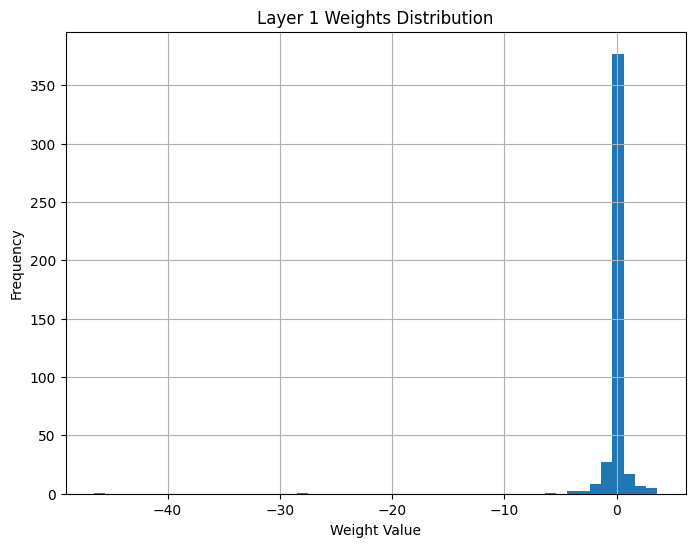

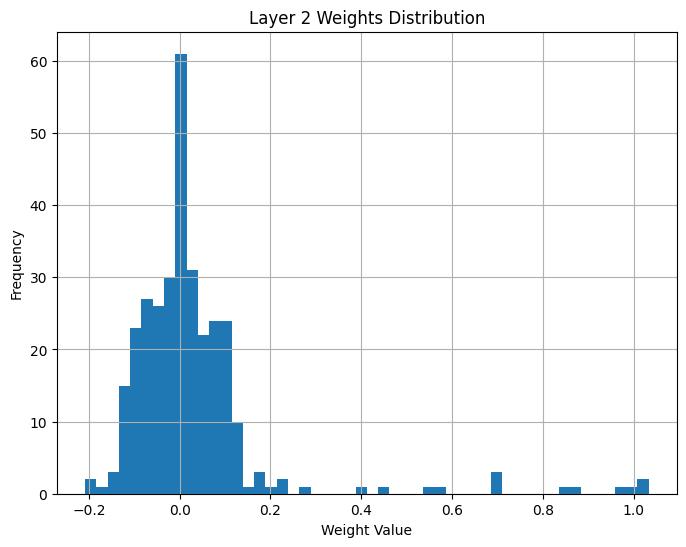

In [209]:
# Extract weights from the model's layers
def extract_weights(model):
    weights = []
    for name, param in model.named_parameters():
        if 'weight' in name:
            weights.append(param.detach().numpy())
    return weights

# Get the weights from the model
model_weights = extract_weights(model)

# Visualize the weights of each layer
for i, layer_weights in enumerate(model_weights, 1):
    plt.figure(figsize=(8, 6))
    plt.hist(layer_weights.flatten(), bins=50)
    plt.title(f"Layer {i} Weights Distribution")
    plt.xlabel("Weight Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

In [210]:
def display_menu(city_coordinates):
    print("Select a city:")
    for index, (city, coordinates) in enumerate(city_coordinates.items(), start=1):
        print(f"{index}. {city}")

In [211]:
def get_city_choice(city_coordinates):
    while True:
        display_menu(city_coordinates)
        choice = input("Enter the number corresponding to the city: ")
        try:
            choice = int(choice)
            if 1 <= choice <= len(city_coordinates):
                city = list(city_coordinates.keys())[choice - 1]
                coordinates = city_coordinates[city]
                return city, coordinates
            else:
                print("Invalid choice. Please enter a valid number.")
        except ValueError:
            print("Invalid input. Please enter a number.")

In [212]:
# Get user's choice of city and coordinates
selected_city, selected_coordinates = get_city_choice(city_coordinates)
print(f"You selected: {selected_city} with coordinates: {selected_coordinates}")

Select a city:
1. Istanbul
2. Ankara
3. İzmir
4. Bursa
5. Antalya
6. Konya
7. Gaziantep
8. Şanlıurfa
9. Mersin
10. Adana
11. Diyarbakır
12. Kayseri
13. Samsun
14. Akçaabat
15. Denizli
16. Çankaya
17. Esenyurt
18. Eskişehir
19. Seyhan
20. Küçükçekmece
21. Erzurum
22. Bağcılar
23. Pendik
24. Selçuklu
25. Yıldırım
26. Kartal
27. Batman
28. Esenler
29. Kahramanmaraş
30. Kâğıthane
31. Avcılar
32. Trabzon
33. Malatya
34. Elazığ
35. Yüreğir
36. Hatay
37. Sivas
38. Gebze
39. Kocaeli
40. Kayapınar
41. Manisa
42. Konak
43. Van
44. Pamukkale
45. Sarıyer
46. Meram
47. Tarsus
48. Balıkesir
49. Beylikdüzü
50. Sultanbeyli
51. Aksaray
52. Alanya
53. Yeşilyurt
54. Adıyaman
55. Afyonkarahisar
56. İskenderun
57. Battalgazi
58. Çorum
59. Güngören
60. Çorlu
61. Sakarya
62. Arnavutköy
63. İnegöl
64. Kütahya
65. Osmaniye
66. Isparta
67. Siverek
68. Tuzla
69. Kızıltepe
70. Uşak
71. Çekme
72. Büyükçekmece
73. Beykoz
74. Düzce
75. Manavgat
76. Ordu
77. Bolu
78. Tekirdağ
79. Tokat
80. Viranşehir
81. Karaköprü
82

In [243]:
# Get the timestamp for today minus 1 hour
input_date = datetime.now() - timedelta(hours=1)
formatted_input_date = input_date.strftime('%Y-%m-%d %H:%M:%S')  # Format the datetime object
prediction_data = [formatted_input_date, selected_city, selected_coordinates[0],selected_coordinates[1]]
prediction_data

['2024-01-08 00:56:18', 'Alanya', 36.55, 32.0]

In [244]:
# Convert string values to floats if possible
prediction_data = [float(item) if isinstance(item, str) and item.replace('.', '', 1).isdigit() else item for item in prediction_data]
prediction_data

['2024-01-08 00:56:18', 'Alanya', 36.55, 32.0]

In [245]:
# Filter out non-numeric elements
prediction_data = [item for item in prediction_data if isinstance(item, float)]
prediction_data

[36.55, 32.0]

In [246]:
# Convert the list to a NumPy array
numpy_array = np.array(prediction_data)
numpy_array

array([36.55, 32.  ])

In [247]:
# Create a PyTorch tensor from the NumPy array
torch_tensor = torch.tensor(numpy_array)
torch_tensor

tensor([36.5500, 32.0000], dtype=torch.float64)

In [253]:
model_input_dtype = torch.float32  # Change this to match your model's input type
torch_tensor = torch_tensor.to(model_input_dtype)
# Make predictions using the model
predictions = model(torch_tensor)
print(predictions)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x2 and 7x64)